In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style for better readability
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



In [136]:
full_df = pd.read_csv('C:/Users/prana/OneDrive/Desktop/4trimester/healthcare/data/Clinical_Data_Validation_Cohort.csv')
print("Dataset 'Clinical_Data_Validation_Cohort.csv' loaded successfully.")

    # Define the specific attributes you're interested in
selected_attributes = [
        "Patient ID",
        "Survival time (days)",
        "Event (death: 1, alive: 0)",
        "Tumor size (cm)",
        "Grade",
        "Stage (TNM 8th edition)",
        "Age",
        "Sex",
        "Cigarette",
        "Pack per year",
        "Type.Adjuvant",
        "batch",
        "EGFR",
        "KRAS"
    ]

    # Create a new dataframe with only the selected columns
df = full_df[selected_attributes]
print(f"Data subsetted to {len(df.columns)} selected attributes.")
print(f"Shape of the new data: {df.shape}")

Dataset 'Clinical_Data_Validation_Cohort.csv' loaded successfully.
Data subsetted to 14 selected attributes.
Shape of the new data: (95, 14)


In [137]:
# Clean and standardize column names for easier access
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '_')
print("--- Column Names Cleaned ---")
print(list(df.columns))

# Display the first 5 rows
print("\n--- First 5 Rows of Subsetted Data ---")
print(df.head())

# Get a summary of the dataframe, including data types and non-null counts
print("\n--- Dataframe Info ---")
df.info()

# Check for the number of missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Column Names Cleaned ---
['patient_id', 'survival_time_days', 'event_death:_1,_alive:_0', 'tumor_size_cm', 'grade', 'stage_tnm_8th_edition', 'age', 'sex', 'cigarette', 'pack_per_year', 'type_adjuvant', 'batch', 'egfr', 'kras']

--- First 5 Rows of Subsetted Data ---
  patient_id  survival_time_days  event_death:_1,_alive:_0  tumor_size_cm  \
0    P109342                2329                         1            2.6   
1    P124450                2532                         0            3.5   
2    P131833                2271                         0            2.0   
3    P131888                2193                         0            3.0   
4    P131946                2387                         0            4.0   

   grade stage_tnm_8th_edition  age     sex cigarette  pack_per_year  \
0      3                    IB   67    Male    Former           50.0   
1      3                    IB   68  Female    Former           52.5   
2      2                   IA2   80  Female     Ne

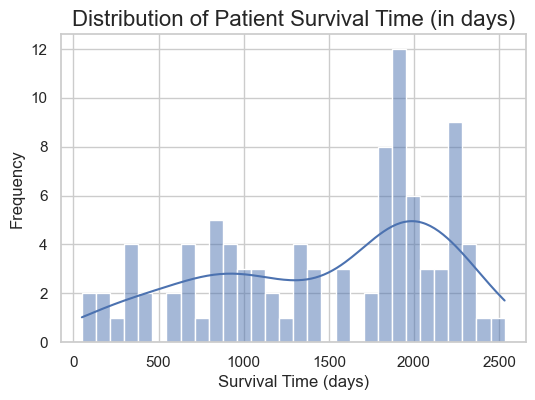

In [138]:
# Distribution of Survival Time
plt.figure(figsize=(6, 4))
sns.histplot(df['survival_time_days'], bins=30, kde=True)
plt.title('Distribution of Patient Survival Time (in days)', fontsize=16)
plt.xlabel('Survival Time (days)')
plt.ylabel('Frequency')
plt.show()


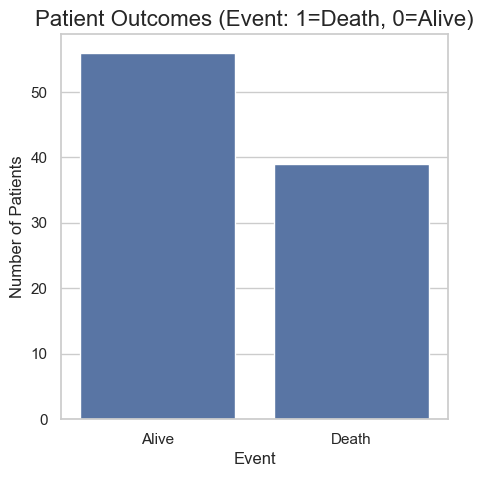

In [139]:
# Count of Events (Death vs. Alive)
plt.figure(figsize=(5, 5))
sns.countplot(x='event_death:_1,_alive:_0', data=df)
plt.title('Patient Outcomes (Event: 1=Death, 0=Alive)', fontsize=16)
plt.xlabel('Event')
plt.ylabel('Number of Patients')
plt.xticks([0, 1], ['Alive', 'Death']) 
plt.show()

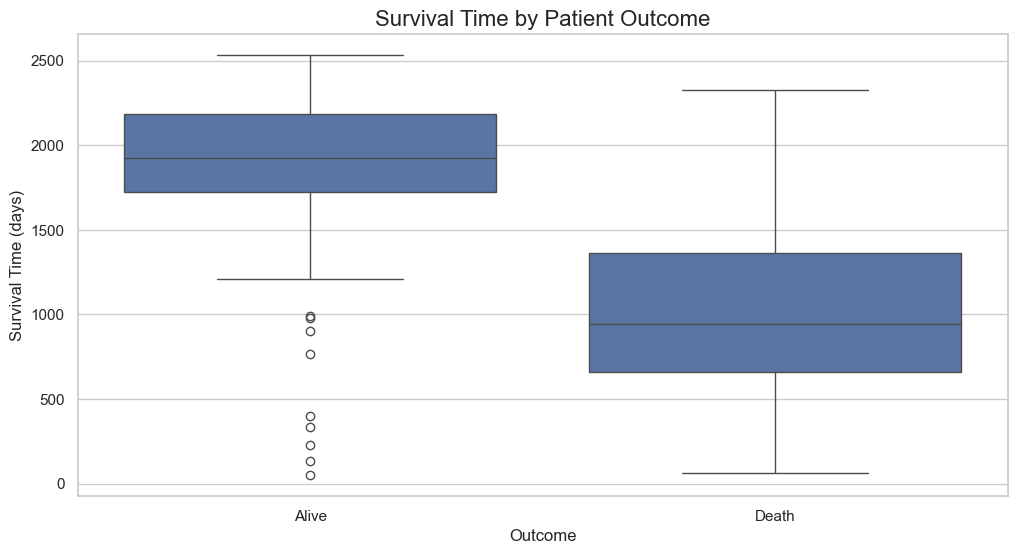

In [140]:
# Survival Time vs. Event Outcome
plt.figure()
sns.boxplot(x='event_death:_1,_alive:_0', y='survival_time_days', data=df)
plt.title('Survival Time by Patient Outcome', fontsize=16)
plt.xlabel('Outcome')
plt.ylabel('Survival Time (days)')
plt.xticks([0, 1], ['Alive', 'Death'])
plt.show()

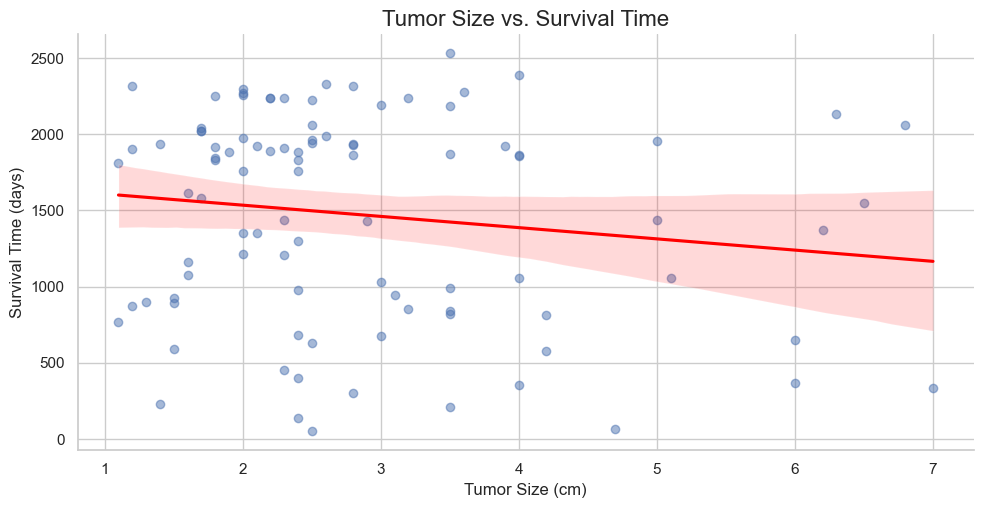

In [141]:
# Tumor Size vs. Survival Time
sns.lmplot(x='tumor_size_cm', y='survival_time_days', data=df, aspect=2,
           line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
plt.title('Tumor Size vs. Survival Time', fontsize=16)
plt.xlabel('Tumor Size (cm)')
plt.ylabel('Survival Time (days)')
plt.show()

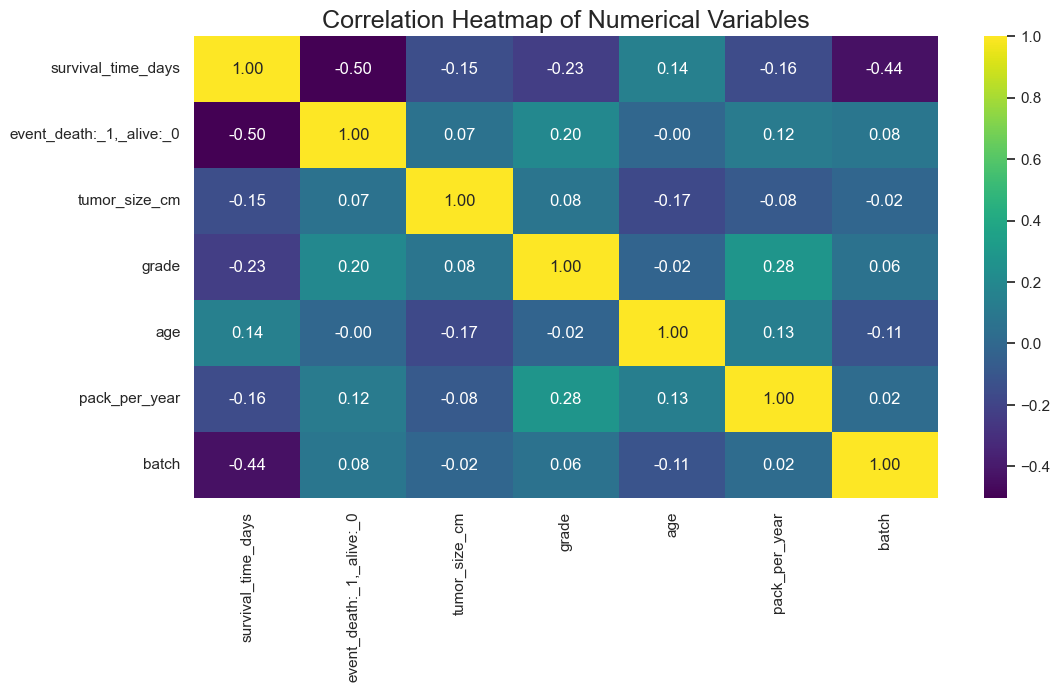

In [142]:
# Select only numeric columns for the correlation matrix
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Variables', fontsize=18)
plt.show()

Models

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Set plot style
sns.set_theme(style="whitegrid")

print("All libraries imported successfully.")

All libraries imported successfully.


In [144]:
# Load the dataset
df = pd.read_csv('C:/Users/prana/OneDrive/Desktop/4trimester/healthcare/data/Clinical_Data_Validation_Cohort.csv')

# Clean column names
# df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '_')

# --- Define Features (X) and Target (y) ---
# The target is the event of death
TARGET = 'Event (death: 1, alive: 0)'


X = df.drop(TARGET, axis=1)
y = df[TARGET]

# --- Identify Column Types for Preprocessing ---
# This is a crucial step for building the pipeline
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

print(f"Target variable: {TARGET}")
print(f"Number of features: {X.shape[1]-1}")
print(f"Numerical features identified: {list(numerical_features)}")
print(f"Categorical features identified: {list(categorical_features)}")

Target variable: Event (death: 1, alive: 0)
Number of features: 11
Numerical features identified: ['Survival time (days)', 'Tumor size (cm)', 'Grade', 'Age', 'Pack per year', 'batch']
Categorical features identified: ['Patient ID', 'Stage (TNM 8th edition)', 'Sex', 'Cigarette', 'Type.Adjuvant', 'EGFR', 'KRAS']


In [145]:
# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, # for reproducibility
    stratify=y  # Ensures the same proportion of outcomes in train/test sets
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (76, 13)
Testing set shape: (19, 13)


In [146]:
# Create a pipeline for numerical features
# 1. Impute missing values with the median
# 2. Scale features to have a mean of 0 and variance of 1
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features
# 1. Impute missing values with the most frequent value
# 2. One-hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Ignores categories in test set not seen in training
])

# Combine the transformers into a single preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


--- Training Logistic Regression ---
Accuracy: 0.7368
ROC AUC Score: 0.9432

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.38      0.55         8

    accuracy                           0.74        19
   macro avg       0.84      0.69      0.68        19
weighted avg       0.82      0.74      0.70        19



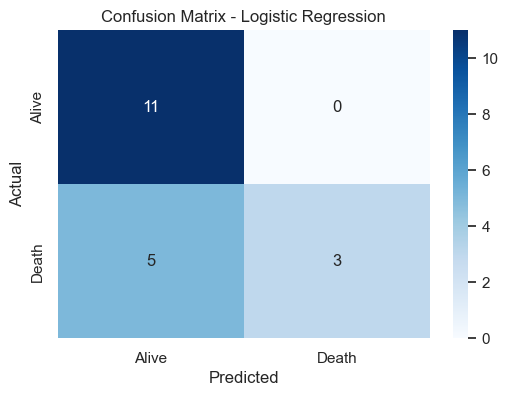



--- Training Random Forest ---
Accuracy: 0.6842
ROC AUC Score: 0.9659

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       1.00      0.25      0.40         8

    accuracy                           0.68        19
   macro avg       0.82      0.62      0.59        19
weighted avg       0.80      0.68      0.62        19



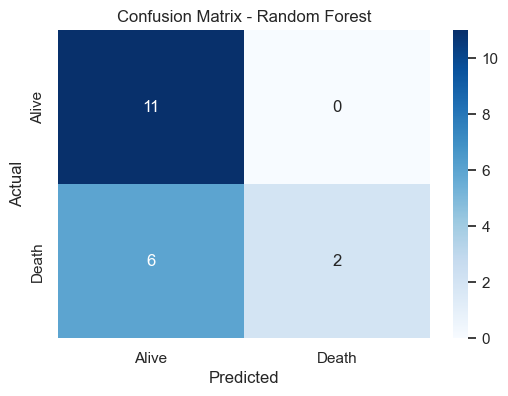



--- Training XGBoost ---
Accuracy: 0.9474
ROC AUC Score: 0.9545

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.88      0.93         8

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19



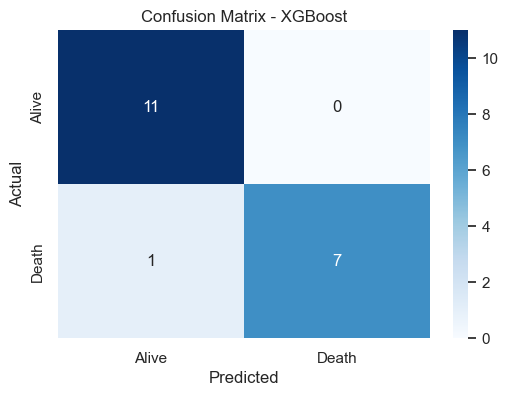

In [ ]:
# Define the models we want to compare
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter= 1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',)
}

# Dictionary to store results
results = {}

for model_name, model in models.items():
    
    # --- Create the full pipeline ---
    # This chains the preprocessor with the model
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # --- Train the model ---
    print(f"--- Training {model_name} ---")
    full_pipeline.fit(X_train, y_train)
    
    # --- Make predictions ---
    y_pred = full_pipeline.predict(X_test)
    y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1] # Probability for the positive class
    
    # --- Evaluate ---
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[model_name] = {'accuracy': accuracy, 'roc_auc': roc_auc}
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\n" + "="*50 + "\n")

In [151]:
# This cell goes after your model training and evaluation cell

from sklearn.model_selection import GridSearchCV

# We will focus on tuning our best model: XGBoost
# First, create the pipeline without the final classifier
pipeline_base = Pipeline(steps=[('preprocessor', preprocessor)])

# Define a 'grid' of hyperparameters to search through.
# These are some of the most important ones for XGBoost.
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# Create the final pipeline with an XGBoost classifier placeholder
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])


# Set up GridSearchCV
# cv=5 means 5-fold cross-validation
# n_jobs=-1 means use all available CPU cores to speed up the search
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=2)

print("--- Starting Hyperparameter Tuning for XGBoost ---")
grid_search.fit(X_train, y_train)

print("\nBest parameters found: ", grid_search.best_params_)
print("Best ROC AUC score on cross-validation: ", grid_search.best_score_)

# Evaluate the best model found by the grid search on our test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print("\n--- Performance of Tuned XGBoost Model on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")
print(classification_report(y_test, y_pred_tuned))

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found:  {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best ROC AUC score on cross-validation:  0.7206349206349205

--- Performance of Tuned XGBoost Model on Test Set ---
Accuracy: 0.9474
ROC AUC Score: 0.9205
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.88      0.93         8

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19



C:\Users\prana\AppData\Local\Temp\ipykernel_24160\983006111.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='mako')


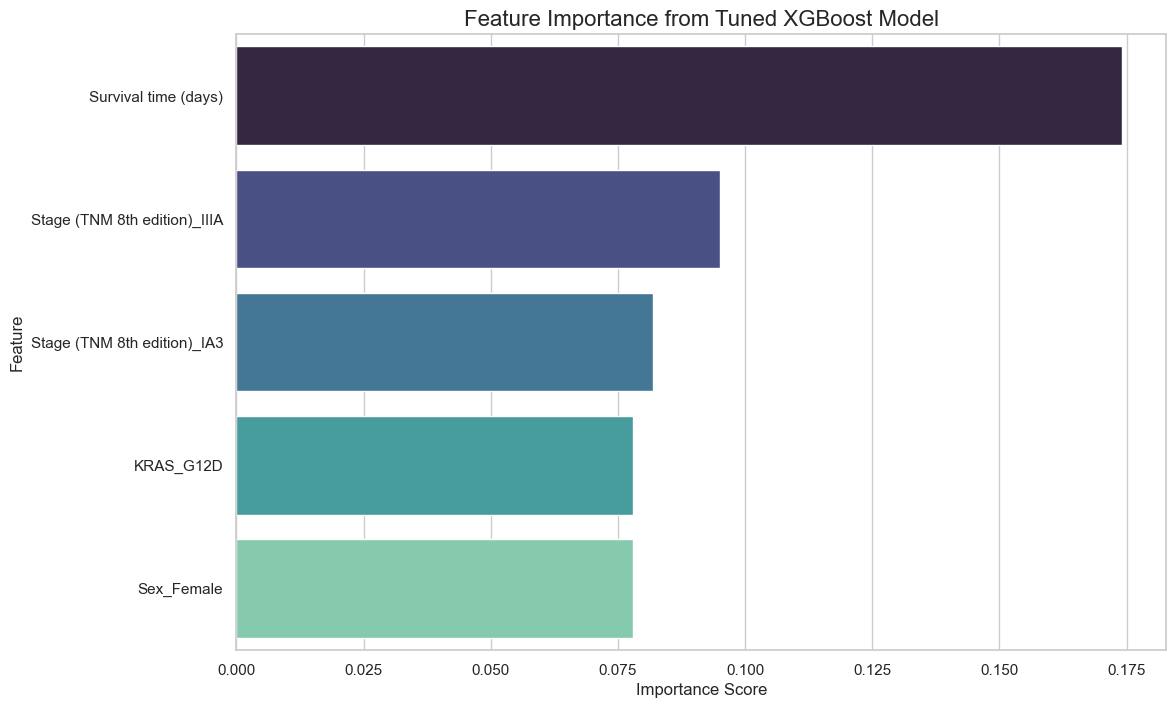

In [154]:
# This cell goes after the hyperparameter tuning cell

# Use the best model from our grid search
best_xgb_model = grid_search.best_estimator_.named_steps['classifier']

# Get the preprocessor from the trained pipeline
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Get the feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_feature_names])

# Create a pandas Series for easy plotting
importances = pd.Series(best_xgb_model.feature_importances_, index=all_feature_names)

# Sort by importance
sorted_importances = importances.sort_values(ascending=False).head(5)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='mako')
plt.title('Feature Importance from Tuned XGBoost Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [155]:
import joblib

# The 'best_model' is the entire pipeline (preprocessor + tuned classifier)
# This is the object you want to save.
model_filename = 'final_patient_outcome_model.pkl'

print(f"Saving the best model to '{model_filename}'...")
joblib.dump(best_model, model_filename)
print("✅ Model saved successfully!")

# You can load it back anytime like this:
loaded_model = joblib.load(model_filename)
print("\nModel loaded successfully.")
predictions = loaded_model.predict(X_test)

Saving the best model to 'final_patient_outcome_model.pkl'...
✅ Model saved successfully!

Model loaded successfully.
